In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
# from rf_classification import get_data

### Bias/Variance

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [66]:
NUM_DATASETS = 50
NOISE_VARIANCE = 0.5
MAX_POLY = 12
N = 25
Ntrain = int(0.9*N)

np.random.seed(2)

# make a dataset with x^D, x^(D-1), ..., x^0
def make_poly(x, D):
  N = len(x)
  X = np.empty((N, D+1))
  for d in range(D+1):
    X[:,d] = x**d
    if d > 1:
      X[:,d] = (X[:,d] - X[:,d].mean()) / X[:,d].std()
  return X

def f(X):
  return np.sin(X)

In [67]:
x_axis = np.linspace(-np.pi, np.pi, 100)
y_axis = f(x_axis)

In [68]:
X = np.linspace(-np.pi, np.pi, N)
np.random.shuffle(X)

f_X = f(X)
Xpoly = make_poly(X, MAX_POLY)

In [69]:
train_scores = np.zeros((NUM_DATASETS, MAX_POLY))
test_scores = np.zeros((NUM_DATASETS, MAX_POLY))
train_predictions = np.zeros((Ntrain, NUM_DATASETS, MAX_POLY))
prediction_curves = np.zeros((100, NUM_DATASETS, MAX_POLY))

In [70]:
model = LinearRegression()

for k in range(NUM_DATASETS):
  Y = f_X + np.random.randn(N)*NOISE_VARIANCE

  Xtrain = Xpoly[:Ntrain]
  Ytrain = Y[:Ntrain]

  Xtest = Xpoly[Ntrain:]
  Ytest = Y[Ntrain:]

  for d in range(MAX_POLY):
    model.fit(Xtrain[:,:d+2], Ytrain)
    predictions = model.predict(Xpoly[:,:d+2])

    # debug
    x_axis_poly = make_poly(x_axis, d+1)
    prediction_axis = model.predict(x_axis_poly)

    prediction_curves[:,k,d] = prediction_axis

    train_prediction = predictions[:Ntrain]
    test_prediction = predictions[Ntrain:]

    train_predictions[:,k,d] = train_prediction # use this to calculate bias/variance later

    train_score = mse(train_prediction, Ytrain)
    test_score = mse(test_prediction, Ytest)

    train_scores[k,d] = train_score
    test_scores[k,d] = test_score

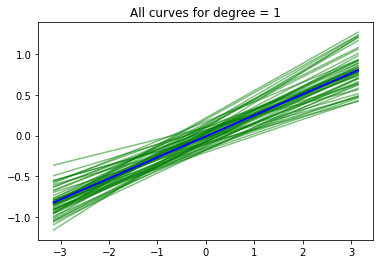

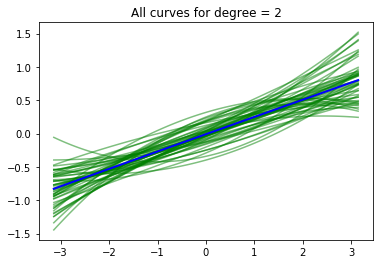

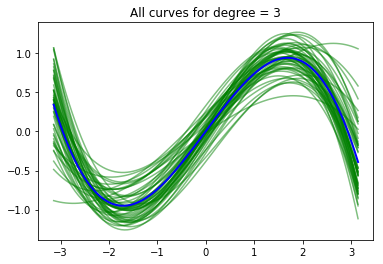

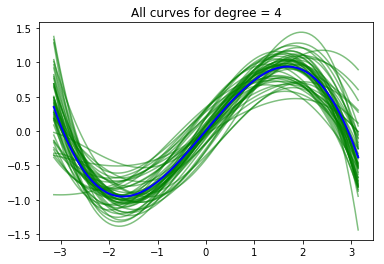

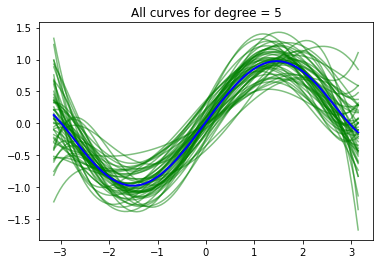

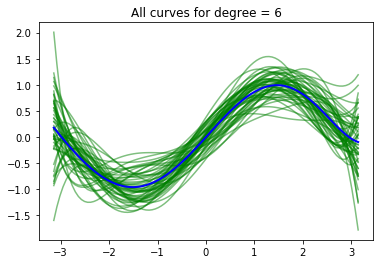

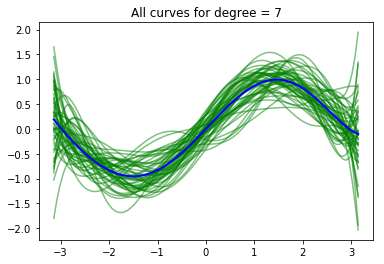

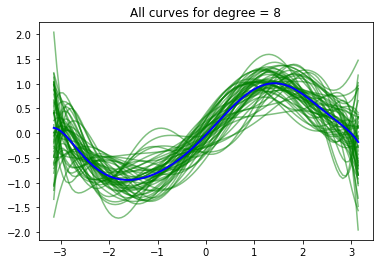

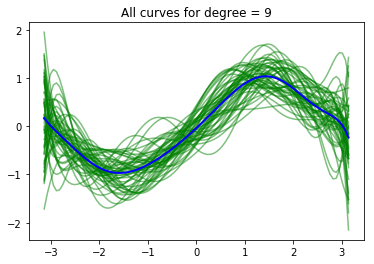

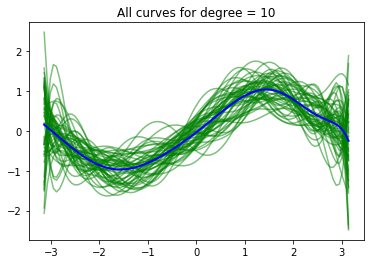

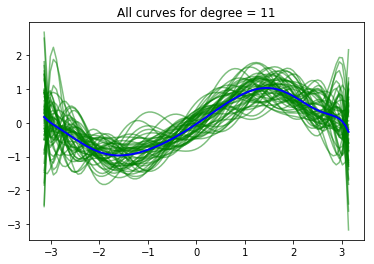

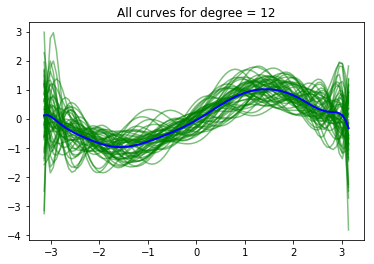

In [71]:
for d in range(MAX_POLY):
  for k in range(NUM_DATASETS):
    plt.plot(x_axis, prediction_curves[:,k,d], color='green', alpha=0.5)
  plt.plot(x_axis, prediction_curves[:,:,d].mean(axis=1), color='blue', linewidth=2.0)
  plt.title("All curves for degree = %d" % (d+1))
  plt.show()

In [72]:
# Squared Bias
avg_train_prediction = np.zeros((Ntrain, MAX_POLY))
squared_bias = np.zeros(MAX_POLY)
f_Xtrain = f_X[:Ntrain]
for d in range(MAX_POLY):
  for i in range(Ntrain):
    avg_train_prediction[i,d] = train_predictions[i,:,d].mean()
  squared_bias[d] = ((avg_train_prediction[:,d] - f_Xtrain)**2).mean()

In [73]:
variances = np.zeros((Ntrain, MAX_POLY))
for d in range(MAX_POLY):
  for i in range(Ntrain):
    delta = train_predictions[i,:,d] - avg_train_prediction[i,d]
    variances[i,d] = delta.dot(delta) / len(delta)
variance = variances.mean(axis=0)

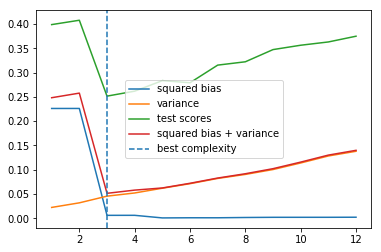

In [74]:
degrees = np.arange(MAX_POLY) + 1
best_degree = np.argmin(test_scores.mean(axis=0)) + 1
plt.plot(degrees, squared_bias, label='squared bias')
plt.plot(degrees, variance, label='variance')
plt.plot(degrees, test_scores.mean(axis=0), label='test scores')
plt.plot(degrees, squared_bias + variance, label='squared bias + variance')
plt.axvline(x=best_degree, linestyle='--', label='best complexity')
plt.legend()
plt.show()

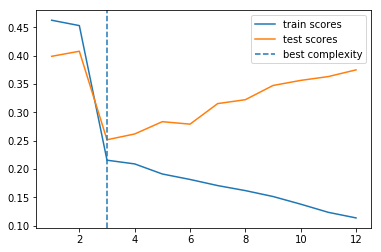

In [75]:
plt.plot(degrees, train_scores.mean(axis=0), label='train scores')
plt.plot(degrees, test_scores.mean(axis=0), label='test scores')
plt.axvline(x=best_degree, linestyle='--', label='best complexity')
plt.legend()
plt.show()

### Random Forrest

In [76]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.utils import shuffle

In [77]:
N = 20
Ntrain = 12

In [82]:
X = np.linspace(0, 2*np.pi, N).reshape(N, 1)
Y = np.sin(3*X)
X, Y = shuffle(X, Y)

In [83]:
Xtrain = X[:Ntrain]
Ytrain = Y[:Ntrain]

In [84]:
model = DecisionTreeRegressor() # default max_depth=None
model.fit(Xtrain, Ytrain)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [85]:
T = 50
Xaxis = np.linspace(0, 2*np.pi, T)
Yaxis = np.sin(3*Xaxis)

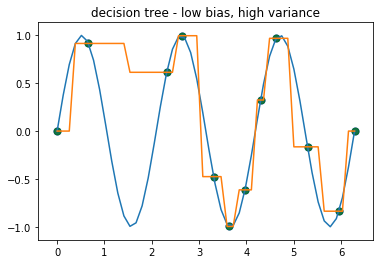

In [87]:
plt.scatter(Xtrain, Ytrain, s=50, alpha=0.7, c='blue')
plt.scatter(Xtrain, model.predict(Xtrain.reshape(Ntrain, 1)), s=50, alpha=0.7, c='green')
plt.title("decision tree - low bias, high variance")
plt.plot(Xaxis, Yaxis)
plt.plot(Xaxis, model.predict(Xaxis.reshape(T, 1)))
plt.show()

In [88]:
model2 = DecisionTreeRegressor(max_depth=1) # default max_depth=None
model2.fit(Xtrain, Ytrain)

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

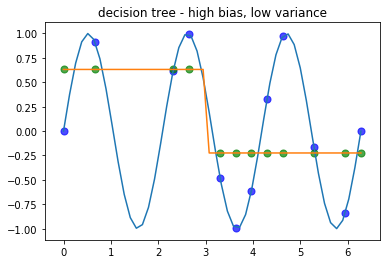

In [95]:
plt.scatter(Xtrain, Ytrain, s=50, alpha=0.7, c='blue')
plt.scatter(Xtrain, model2.predict(Xtrain.reshape(Ntrain, 1)), s=50, alpha=0.7, c='green')
plt.title("decision tree - high bias, low variance")
plt.plot(Xaxis, Yaxis)
plt.plot(Xaxis, model2.predict(Xaxis.reshape(T, 1)))
plt.show()

In [91]:
model_knn = KNeighborsRegressor(n_neighbors=1) 
model_knn.fit(Xtrain, Ytrain)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform')

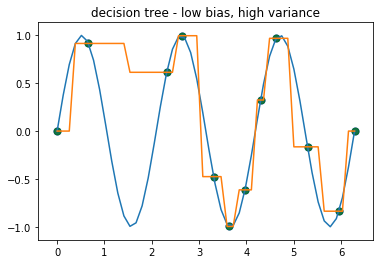

In [92]:
plt.scatter(Xtrain, Ytrain, s=50, alpha=0.7, c='blue')
plt.scatter(Xtrain, model_knn.predict(Xtrain.reshape(Ntrain, 1)), s=50, alpha=0.7, c='green')
plt.title("decision tree - low bias, high variance")
plt.plot(Xaxis, Yaxis)
plt.plot(Xaxis, model_knn.predict(Xaxis.reshape(T, 1)))
plt.show()

In [93]:
model_knn2 = KNeighborsRegressor(n_neighbors=10) # default max_depth=None
model_knn2.fit(Xtrain, Ytrain)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

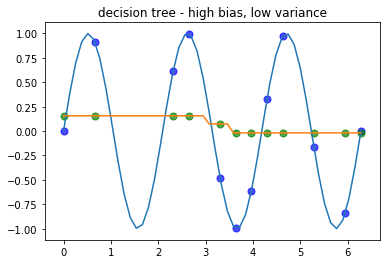

In [96]:
plt.scatter(Xtrain, Ytrain, s=50, alpha=0.7, c='blue')
plt.scatter(Xtrain, model_knn2.predict(Xtrain.reshape(Ntrain, 1)), s=50, alpha=0.7, c='green')
plt.title("decision tree - high bias, low variance")
plt.plot(Xaxis, Yaxis)
plt.plot(Xaxis, model_knn2.predict(Xaxis.reshape(T, 1)))
plt.show()

#### Classification

In [98]:
N = 100
D = 2
X = np.random.randn(N, D)
X[:N//2] += np.array([1, 1]) # center it at (1,1)
X[N//2:] += np.array([-1, -1]) # center it at (-1, -1)

Y = np.array([0]*(N//2) + [1]*(N//2))

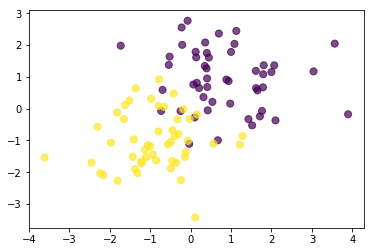

In [99]:
plt.scatter(X[:,0], X[:,1], s=50, c=Y, alpha=0.7)
plt.show()

In [100]:
mod_DTC = DecisionTreeClassifier()
mod_DTC.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [101]:
def plot_decision_boundary(X, model):
  h = .02  # step size in the mesh
  # create a mesh to plot in
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))


  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, m_max]x[y_min, y_max].
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

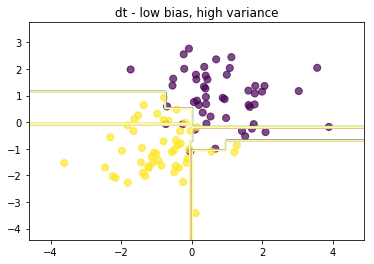

In [102]:
plt.scatter(X[:,0], X[:,1], s=50, c=Y, alpha=0.7)
plot_decision_boundary(X, mod_DTC)
plt.title("dt - low bias, high variance")
plt.show()

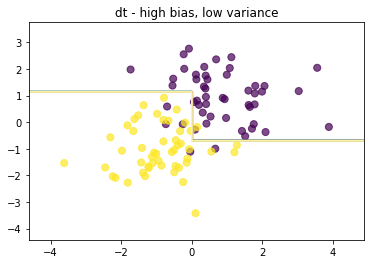

In [103]:
mod_DTC2 = DecisionTreeClassifier(max_depth=2)
mod_DTC2.fit(X, Y)

plt.scatter(X[:,0], X[:,1], s=50, c=Y, alpha=0.7)
plot_decision_boundary(X, mod_DTC2)
plt.title("dt - high bias, low variance")
plt.show()

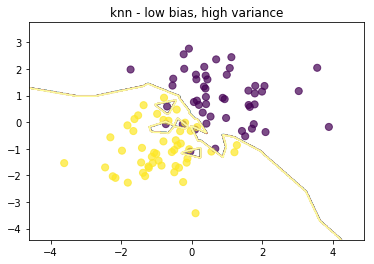

In [104]:
mod_KNN = KNeighborsClassifier(n_neighbors=1)
mod_KNN.fit(X, Y)

plt.scatter(X[:,0], X[:,1], s=50, c=Y, alpha=0.7)
plot_decision_boundary(X, mod_KNN)
plt.title("knn - low bias, high variance")
plt.show()


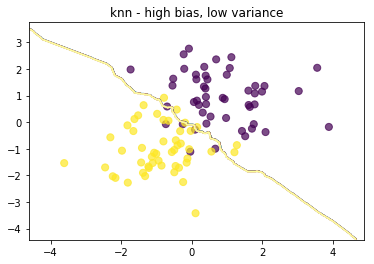

In [105]:
mod_KNN2 = KNeighborsClassifier(n_neighbors=20)
mod_KNN2.fit(X, Y)

plt.scatter(X[:,0], X[:,1], s=50, c=Y, alpha=0.7)
plot_decision_boundary(X, mod_KNN2)
plt.title("knn - high bias, low variance")
plt.show()

### Cross-Validation

"Choosing the BEST hyperparameters" to find the optimal model complexity

### Bootstrapping 

Ability to lower bias and variance at the same time by averaging several models 

In [112]:
from scipy.stats import norm, t

In [106]:
B = 200
N = 20
X = np.random.randn(N)

In [107]:
print("Sample mean of X:", X.mean())

Sample mean of X: 0.25228208752360676


In [109]:
individual_estimates = np.empty(B)
for b in range(B):
    sample = np.random.choice(X, size=N)
    individual_estimates[b] = sample.mean()

In [113]:
bmean = individual_estimates.mean()
bstd = individual_estimates.std()

lower = bmean + norm.ppf(0.025)*bstd
upper = bmean + norm.ppf(0.975)*bstd

In [116]:
# traditional way of calculating CI
lower2 = X.mean() + norm.ppf(0.025)*X.std()/np.sqrt(N)
upper2 = X.mean() + norm.ppf(0.975)*X.std()/np.sqrt(N)

In [117]:
print("bootstrap mean of X:", bmean)

bootstrap mean of X: 0.24669820716503515


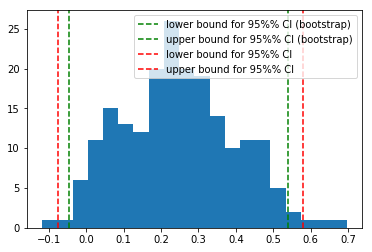

In [118]:
plt.hist(individual_estimates, bins=20)
plt.axvline(x=lower, linestyle='--', color='g', label="lower bound for 95%% CI (bootstrap)")
plt.axvline(x=upper, linestyle='--', color='g', label="upper bound for 95%% CI (bootstrap)")
plt.axvline(x=lower2, linestyle='--', color='r', label="lower bound for 95%% CI")
plt.axvline(x=upper2, linestyle='--', color='r', label="upper bound for 95%% CI")
plt.legend()
plt.show()

### Bagging

Bagging = bootstrap aggregating = application of bootstrap to ML models

Exactly like bootstrapping instead of calculating a $\hat{\theta}$ we train a model...

Classification is harder b/c of the collection of votes BUT... a classifier can use averaging if it just returns class probabilities

#### Bagged Regressor

In [119]:
# Bagging for Regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle

T = 100
x_axis = np.linspace(9, 2*np.pi, T)
y_axis = np.sin(x_axis)

N = 30
idx = np.random.choice(T, size=N, replace=False)
Xtrain = x_axis[idx].reshape(N, 1)
Ytrain = y_axis[idx]


In [120]:
model = DecisionTreeRegressor()
model.fit(Xtrain, Ytrain)
prediction = model.predict(x_axis.reshape(T, 1))
print("Score for 1 tree:", model.score(x_axis.reshape(T,1), y_axis))

Score for 1 tree: 0.9872364732428053


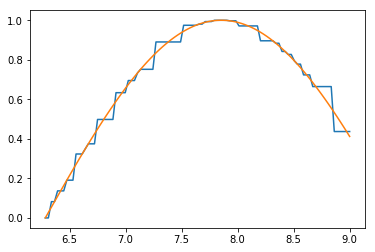

In [121]:
plt.plot(x_axis, prediction)
plt.plot(x_axis, y_axis)
plt.show()

In [128]:
class BaggedTreeRegressor:
    
  def __init__(self, B):
    self.B = B

  def fit(self, X, Y):
    N = len(X)
    self.models = []
    for b in range(self.B):
      idx = np.random.choice(N, size=N, replace=True)
      Xb = X[idx]
      Yb = Y[idx]

      model = DecisionTreeRegressor()
      model.fit(Xb, Yb)
      self.models.append(model)

  def predict(self, X):
    predictions = np.zeros(len(X))
    for model in self.models:
      predictions += model.predict(X)
    return predictions / self.B

  def score(self, X, Y):
    d1 = Y - self.predict(X)
    d2 = Y - Y.mean()
    return 1 - d1.dot(d1) / d2.dot(d2)

In [129]:
model = BaggedTreeRegressor(200)
model.fit(Xtrain, Ytrain)
print("score for bagged tree:", model.score(x_axis.reshape(T, 1), y_axis))
prediction = model.predict(x_axis.reshape(T, 1))

score for bagged tree: 0.9894412719732395


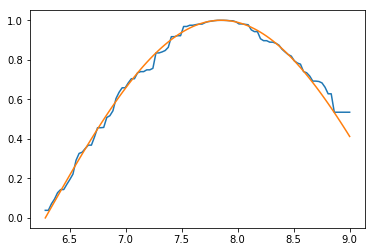

In [130]:
plt.plot(x_axis, prediction)
plt.plot(x_axis, y_axis)
plt.show()

#### Bagged Classifier

In [131]:
from sklearn.tree import DecisionTreeClassifier
from util import plot_decision_boundary

ModuleNotFoundError: No module named 'util'

In [132]:
np.random.seed(10)

# Manufacture simulated data
N = 500
D = 2
X = np.random.randn(N, D)

In [135]:
# Noisy XOR
sep = 2
X[:125] += np.array([sep, sep])
X[125:250] += np.array([sep, -sep])
X[250:375] += np.array([-sep, -sep])
X[375:] += np.array([-sep, sep])

Y = np.array([0]*125 + [1]*125 + [0]*125 + [1]*125)


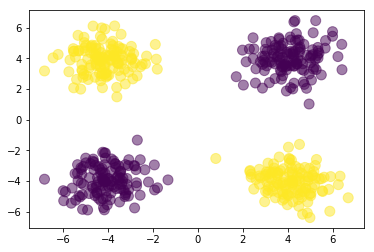

In [136]:
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plt.show()

In [138]:
model = DecisionTreeClassifier()
model.fit(X, Y)
print("Score for baseline tree:", model.score(X, Y))

Score for baseline tree: 1.0


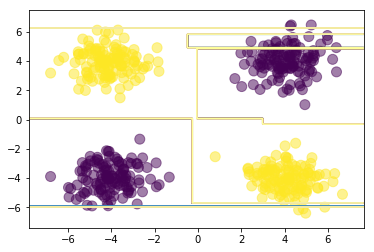

In [139]:
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plot_decision_boundary(X, model)
plt.show()

In [140]:
class BaggedTreeClassifier:
    
    def __init__(self, B):
        self.B = B
        
    def fit(self, X, Y):
        N = len(X)
        self.models = []
        for b in range(self.B):
            idx = np.random.choice(N, size=N, replace=True)
            Xb = X[idx]
            Yb = Y[idx]
            
            model = DecisionTreeClassifier(max_depth=2)
            model.fit(Xb, Yb)
            self.models.append(model)
            
    def predict(self, X):
        predictions = np.zeros(len(X))
        for model in self.models:
            predictions += model.predict(X)
        return np.round(predictions / B)
    
    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(Y == P)

In [141]:
model = BaggedTreeClassifier(200)
model.fit(X, Y)

print("Score for bagged model:", model.score(X, Y))

Score for bagged model: 0.978


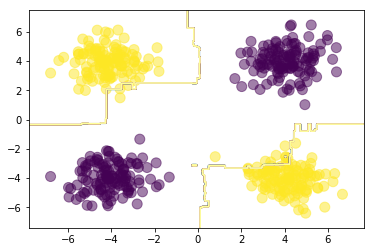

In [142]:
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plot_decision_boundary(X, model)
plt.show()

### Stacking

A special way of combining models with a weighting for each model's contribution

Weighting models

$$f(x)=\sum_{m=1}^M w_{m}f_{m}(x)$$

How do we find the weights by stacking techniques: minimize MSE

$$\hat{w}=argmin_{w}E_{POP}\big[(Y-f(X))^2\big]$$
$$\hat{w}=argmin_{w}E_{POP}\big[(Y-\sum_{m=1}^M w_{m}f_{m}(x)\big]^2$$

Train on all points except $(x_{i}, y_{i})$ calculate error over every ith pair

$$\hat{w}_{stack}=argmin_{w}\big[(Y-\sum_{m=1}^M w_{m}f_{m}^{-i}(x_{i})\big]^2$$

$f_{m}^{-i}(x)=m^{th}$ model trained on all data except $(x_{i}, y_{i})$

Use QP (Quadratic Programming) approach to finding the appropriate weights

$$minimize: \sum_{i=1}^N\bigg[y_{i}-\sum_{m=1}^M w_{m}f_{m}^{-1}(x_{i})\bigg]^2$$

subject to: $w_{m}\geq0, \forall m \neq m^*$

## Random Forest Algorithm

RF is sometimes referred to as "feature bagging"

**Advantage of RF**
- Fast, very little tuning & plug & play

**Disadvantage of RF**
- Tend to overfit

Tries to build a set of trees that are decorrelated from each other therefore achieves a low bias but high variance (overfit)

We cab decorrelate the trees by choosing which features $d$ to train on. The following is the recommended dimensionality $d$

$$\text{classification:}\ d=floor(\sqrt{D})$$
$$\text{regression:}\ d=floor(D/3)$$

For classification the default criterion is "Gini impurity" and the regressor is MSE

In [17]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston

boston_dataset = load_boston()

NUMERICAL_COLS = [
  'crim', # numerical
  'zn', # numerical
  'nonretail', # numerical
  'nox', # numerical
  'rooms', # numerical
  'age', # numerical
  'dis', # numerical
  'rad', # numerical
  'tax', # numerical
  'ptratio', # numerical
  'b', # numerical
  'lstat', # numerical
]

NO_TRANSFORM = ['river']


In [8]:
class DataTransformer:
    def fit(self, df):
        self.scalers = {}
        for col in NUMERICAL_COLS:
          scaler = StandardScaler()
          scaler.fit(df[col].values.reshape(-1, 1))
          self.scalers[col] = scaler

    def transform(self, df):
        N, _ = df.shape
        D = len(NUMERICAL_COLS) + len(NO_TRANSFORM)
        X = np.zeros((N, D))
        i = 0
        for col, scaler in iteritems(self.scalers):
          X[:,i] = scaler.transform(df[col].values.reshape(-1, 1)).flatten()
          i += 1
        for col in NO_TRANSFORM:
          X[:,i] = df[col]
          i += 1
        return X

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

In [23]:
def get_data():
    df = pd.read_csv('./data/hou_all.csv', header=None, 
                     engine='python')
    len(df)
    df.columns = [
        'crim', # numerical
        'zn', # numerical
        'nonretail', # numerical
        'river', # binary
        'nox', # numerical
        'rooms', # numerical
        'age', # numerical
        'dis', # numerical
        'rad', # numerical
        'tax', # numerical
        'ptratio', # numerical
        'b', # numerical
        'lstat', # numerical
        'medv', # numerical -- this is the target
        'biascol'
      ]
    df.drop(['biascol'], axis=1, inplace=True)
    # transform the data
    transformer = DataTransformer()

    # shuffle the data
    N = len(df)
    train_idx = np.random.choice(N, size=int(0.7*N), replace=False)
    test_idx = [i for i in range(N) if i not in train_idx]
    df_train = df.loc[train_idx]
    df_test = df.loc[test_idx]

    Xtrain = transformer.fit_transform(df_train)
    Ytrain = np.log(df_train['medv'].values)
    Xtest = transformer.transform(df_test)
    Ytest = np.log(df_test['medv'].values)
    return Xtrain, Ytrain, Xtest, Ytest

/Users/marktblack/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/marktblack/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/marktblack/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/marktblack/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/marktblack/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595:

ymin: 2.0 ymax: 4.0


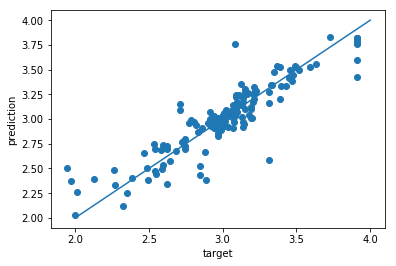

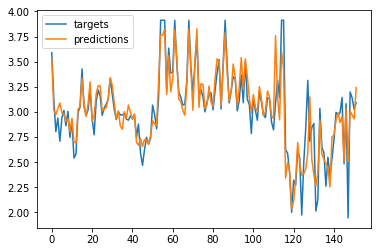

/Users/marktblack/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/marktblack/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/marktblack/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CV single tree: 0.7229930884204759
CV baseline: 0.789483056447542
CV forest: 0.8288685647602446
test score single tree: 0.7046441338517091
test score baseline: 0.680935214856443
test score forest: 0.8146101768280417


In [24]:
if __name__ == '__main__':
  Xtrain, Ytrain, Xtest, Ytest = get_data()

  model = RandomForestRegressor(n_estimators=100) # try 10, 20, 50, 100, 200
  model.fit(Xtrain, Ytrain)
  predictions = model.predict(Xtest)

  # plot predictions vs targets
  plt.scatter(Ytest, predictions)
  plt.xlabel("target")
  plt.ylabel("prediction")
  ymin = np.round( min( min(Ytest), min(predictions) ) )
  ymax = np.ceil( max( max(Ytest), max(predictions) ) )
  print("ymin:", ymin, "ymax:", ymax)
  r = range(int(ymin), int(ymax) + 1)
  plt.plot(r, r)
  plt.show()

  plt.plot(Ytest, label='targets')
  plt.plot(predictions, label='predictions')
  plt.legend()
  plt.show()

  # do a quick baseline test
  baseline = LinearRegression()
  single_tree = DecisionTreeRegressor()
  print("CV single tree:", cross_val_score(single_tree, Xtrain, Ytrain).mean())
  print("CV baseline:", cross_val_score(baseline, Xtrain, Ytrain).mean())
  print("CV forest:", cross_val_score(model, Xtrain, Ytrain).mean())

  # test score
  single_tree.fit(Xtrain, Ytrain)
  baseline.fit(Xtrain, Ytrain)
  print("test score single tree:", single_tree.score(Xtest, Ytest))
  print("test score baseline:", baseline.score(Xtest, Ytest))
  print("test score forest:", model.score(Xtest, Ytest))

#### OLS

In [10]:
from sklearn.linear_model import LinearRegression

model_OLS = LinearRegression()
model_OLS.fit(Xtrain, Ytrain)
predictions_OLS = model_OLS.predict(Xtest)

ymin: 2.0 ymax: 4.0


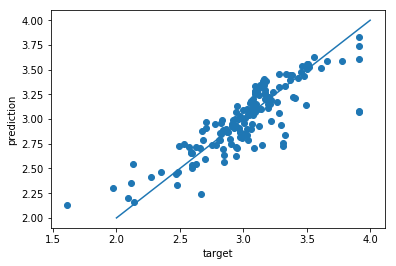

In [11]:
plt.scatter(Ytest, predictions_OLS)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round( min( min(Ytest), min(predictions_OLS) ) )
ymax = np.ceil( max( max(Ytest), max(predictions_OLS) ) )
print("ymin:", ymin, "ymax:", ymax)
r = range(int(ymin), int(ymax) + 1)
plt.plot(r, r)
plt.show()

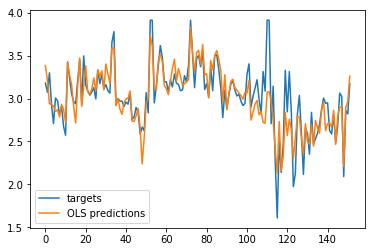

In [12]:
plt.plot(Ytest, label='targets')
plt.plot(predictions_OLS, label='OLS predictions')
plt.legend()
plt.show()

In [14]:
import statsmodels.api as sm

Xtrain = sm.add_constant(Xtrain)

ols_results = sm.OLS(Ytrain, Xtrain).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     107.5
Date:                Sun, 07 Apr 2019   Prob (F-statistic):          7.89e-112
Time:                        11:23:46   Log-Likelihood:                 92.105
No. Observations:                 354   AIC:                            -156.2
Df Residuals:                     340   BIC:                            -102.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0346      0.011    288.457      0.0

### Random Forest Classification

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier